# Analysis of ATP data

In [2]:
import sqlite3
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from ipywidgets import VBox


#from sklearn.preprocessing import LabelEncoder, MinMaxScaler
#from sklearn.model_selection import train_test_split


### Comparison of winrates per year  
To start with, we want to give a look at how the players' winrate changed over the years and compare them. We take into consideration all the matches that were played.

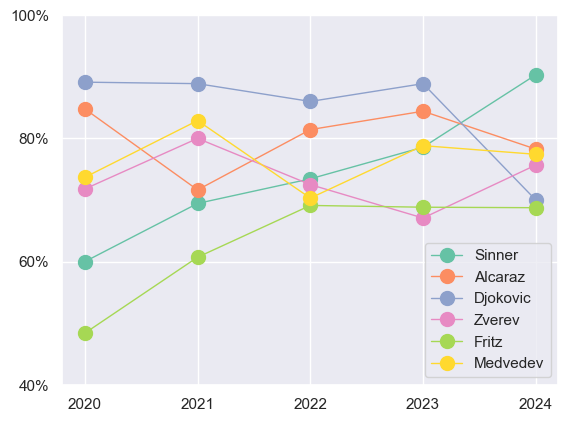

In [3]:
years = [2020, 2021, 2022, 2023, 2024]
players = ["sinner", "alcaraz", "djokovic", "zverev", "fritz", "medvedev"]

# Connect to the db
conn = sqlite3.connect("../data.db")
cur = conn.cursor()

sns.set_theme(palette="Set2")

for name in players:
    wr = []
    for y in years:
        cmd = "SELECT COUNT(*) FROM " + name + " WHERE win='yes' and tourney_date LIKE '" + str(y) + "%';" # count wins
        cur.execute(cmd)
        w = cur.fetchone()[0]
        cmd = "SELECT COUNT(*) FROM " + name + " WHERE win='no' and tourney_date LIKE '" + str(y) + "%';" # count losses
        cur.execute(cmd)
        l = cur.fetchone()[0]
        wr.append(w/(w+l) * 100)
    plt.plot(years, wr, 'o-', label=name.title(), markersize=10, linewidth=1.0)

plt.legend()
#plt.grid()
ax = plt.gca()
ax.set_xticks(years)
ax.set_yticks([40, 60, 80, 100])
ax.set_yticklabels(str(s) + "%" for s in [40, 60, 80, 100])
plt.savefig("./figures/winrate_per_year.png")
plt.show()

### Comparison of winrates on each court including years 2023 and 2024

SELECT COUNT(*) FROM sinner WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';
SELECT COUNT(*) FROM alcaraz WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';
SELECT COUNT(*) FROM djokovic WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';
SELECT COUNT(*) FROM zverev WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';
SELECT COUNT(*) FROM fritz WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';
SELECT COUNT(*) FROM medvedev WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';


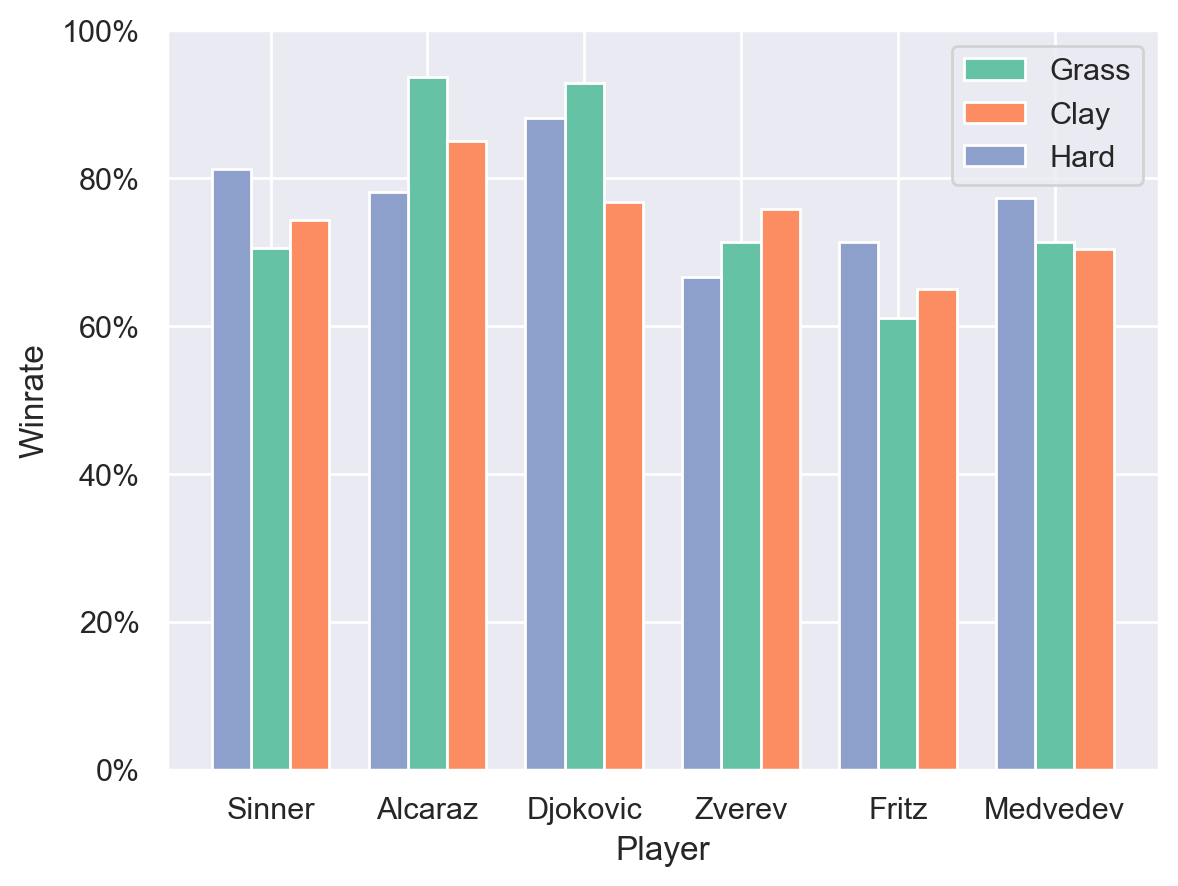

In [7]:

players = ["sinner", "alcaraz", "djokovic", "zverev", "fritz", "medvedev"]
years = [2022, 2023, 2024]
barWidth = 0.25

fig, ax = plt.subplots(dpi=200)

sns.set_theme(palette="Set2")


wr_hard = []
wr_grass = []
wr_clay = []
for name in players:

    year_query = "("
    for y in years:
        year_query += f"tourney_date LIKE '{y}%' OR "
    year_query = year_query[:-4]
    year_query += ") "

    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='yes' AND " + \
            year_query + "AND surface='Hard';"
    print(cmd)
    cur.execute(cmd)
    w = cur.fetchone()[0]
    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='no' AND " + \
            year_query + "AND surface='Hard';"
    cur.execute(cmd)
    l = cur.fetchone()[0]
    wr_hard.append(w / (w+l) * 100)

    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='yes' AND " + \
            year_query + "AND surface='Grass';"
    cur.execute(cmd)
    w = cur.fetchone()[0]
    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='no' AND " + \
        year_query + "AND surface='Grass';"
    cur.execute(cmd)
    l = cur.fetchone()[0]
    wr_grass.append(w / (w+l) * 100)

    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='yes' AND " + \
        year_query + "AND surface='Clay';"
    cur.execute(cmd)
    w = cur.fetchone()[0]
    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='no' AND " + \
        year_query + "AND surface='Clay';"
    cur.execute(cmd)
    l = cur.fetchone()[0]
    wr_clay.append(w / (w+l) * 100)

r = np.arange(len(wr_hard))
r2 = r + barWidth
r3 = r2 + barWidth

ax.bar(r2, wr_grass, width=barWidth, edgecolor='white', label='Grass')
ax.bar(r3, wr_clay, width=barWidth, edgecolor='white', label='Clay')
ax.bar(r, wr_hard, width=barWidth, edgecolor='white', label='Hard')

ax.set_xticks(r + barWidth)
ax.set_xticklabels([p.title() for p in players])

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(str(s) + "%" for s in [0, 20, 40, 60, 80, 100])

plt.xlabel("Player")
plt.ylabel("Winrate")

plt.legend()
plt.savefig("./figures/court_winrates.png")
plt.show()

### Number of aces

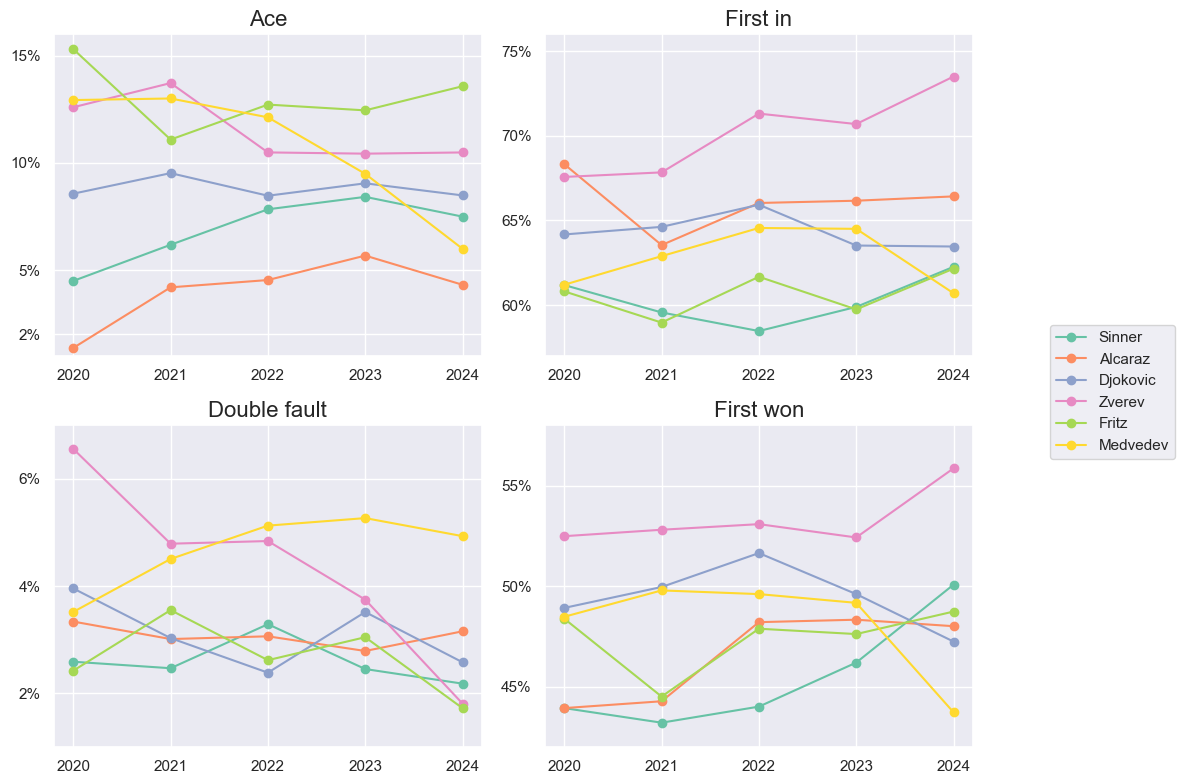

In [5]:
import time

years = [2020, 2021, 2022, 2023, 2024]
players = ["sinner", "alcaraz", "djokovic", "zverev", "fritz", "medvedev"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for name in players:
    ace_values, fin_values, df_values, fwon_values = [[] for _ in range(4)]

    for y in years:

        # Query database
        cmd = f"SELECT firstIn, df, firstWon, ace, serve_points FROM {name} WHERE tourney_date LIKE '%{y}%';"
        cur.execute(cmd)
        results = cur.fetchall()

        # Parse query results
        firstIn = [res[0] for res in results]
        df = [res[1] for res in results]
        firstWon = [res[2] for res in results]
        ace = [res[3] for res in results]
        serve_points = [res[4] for res in results]
        
        # Ace
        values = []
        for v1,v2 in zip(ace, serve_points):
            if v1 is not None and v2 is not None:
                values.append(100 *  v1 / v2)
        ace_values.append(np.average(values))

        # First in
        values = []
        for v1,v2 in zip(firstIn, serve_points):
            if v1 is not None and v2 is not None:
                values.append(100 *  v1 / v2)

        fin_values.append(np.average(values))

        # Double faults
        values = []
        for v1,v2 in zip(df, serve_points):
            if v1 is not None and v2 is not None:
                values.append(100 *  v1 / v2)

        df_values.append(np.average(values))

        # First won
        values = []
        for v1,v2 in zip(firstWon, serve_points):
            if v1 is not None and v2 is not None:
                values.append(100 *  v1 / v2)
        fwon_values.append(np.average(values))

    axes[0,0].plot(years, ace_values, 'o-', label=f"{name}")
    axes[0,1].plot(years, fin_values, 'o-')
    axes[1,0].plot(years, df_values, 'o-')
    axes[1,1].plot(years, fwon_values, 'o-')

axes[0,0].set_yticks([2, 5, 10, 15])
axes[0,1].set_yticks([60, 65, 70, 75])
axes[1,0].set_yticks([2, 4, 6])
axes[1,1].set_yticks([45, 50, 55])

axes[0,0].set_yticklabels(["2%", "5%", "10%", "15%"])
axes[0,1].set_yticklabels(["60%", "65%", "70%", "75%"])
axes[1,0].set_yticklabels(["2%", "4%", "6%"])
axes[1,1].set_yticklabels(["45%", "50%", "55%"])

axes[0,0].set_xticks(years)
axes[0,1].set_xticks(years)
axes[1,0].set_xticks(years)
axes[1,1].set_xticks(years)

axes[0,0].set_ylim([1,16])
axes[0,1].set_ylim([57,76])
axes[1,0].set_ylim([1,7])
axes[1,1].set_ylim([42,58])

axes[0,0].set_title("Ace", fontsize=16)
axes[0,1].set_title("First in", fontsize=16)
axes[1,0].set_title("Double fault", fontsize=16)
axes[1,1].set_title("First won", fontsize=16)

axes[0,0].set_xticks(years)
axes[0,1].set_xticks(years)
axes[1,0].set_xticks(years)
axes[1,1].set_xticks(years)


handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, [name.title() for name in labels], loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
time.sleep(1)
plt.savefig("./figures/serve.png")
